In [1]:
import arsenal_gear as ag
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from time import time

from scipy.integrate import trapezoid as trapz

Initialize a basic stellar population that uses Isochrone-based interpolation and a discrete representation of the underlying stellar population

In [2]:
sp = ag.StellarPopulation(interp_op="iso")

Check the distribution of masses in comparison to the underlying PDF from which it is sampled.

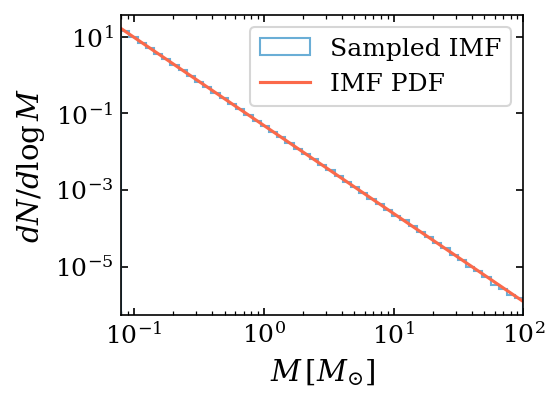

In [3]:
mbins = np.logspace(np.log10(sp.imf.min_mass), np.log10(sp.imf.max_mass), 50)

plt.hist(sp.masses.value, bins=mbins,density=True,histtype='step',color=plt.cm.Blues(0.5),label="Sampled IMF")
plt.plot(mbins, sp.imf._pdf(mbins), color=plt.cm.Reds(0.5), label="IMF PDF")

plt.yscale("log")
plt.xscale("log")
plt.xlim(sp.imf.min_mass, sp.imf.max_mass)
plt.xlabel(r"$M \, [M_{\odot}]$")
plt.ylabel(r"$dN/d\log M$")
plt.legend()

Plot the specifc SN rate for the population at a sample of different times

(1e-05, 0.0008)

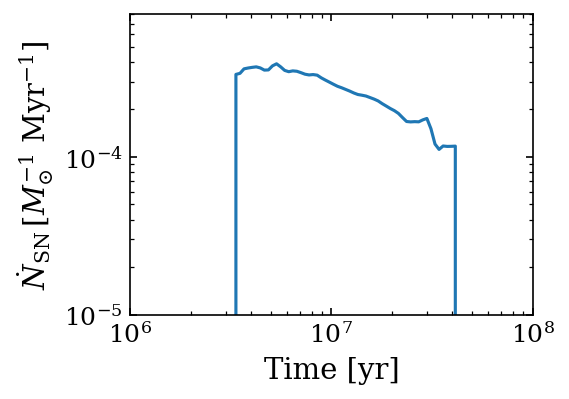

In [4]:
tlin = np.logspace(6,8,100)*u.yr
plt.plot(tlin, sp.ndotsn(tlin)/sp.Mtot.value, label="Cumulative SNe")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time [yr]")
plt.ylabel(r"$\dot{N}_{\rm SN}\, [M_{\odot}^{-1}\,\,\mathrm{Myr}^{-1}]$")

plt.xlim(1e6,1e8)
plt.ylim(1e-5,8e-4)

Construct the isochrone for the population, first each star in the discrete population, and then the underlying isochrone that is created to interpolate the isochrone to. Output timing for each to give an idea of how long these things take. As you can see, a good fraction of the time goes in to simply constructing the isochrone.

Isochrone interpolation time: 0.7985 s
Isochrone construction time: 0.3793 s


(-2.0, 6.0)

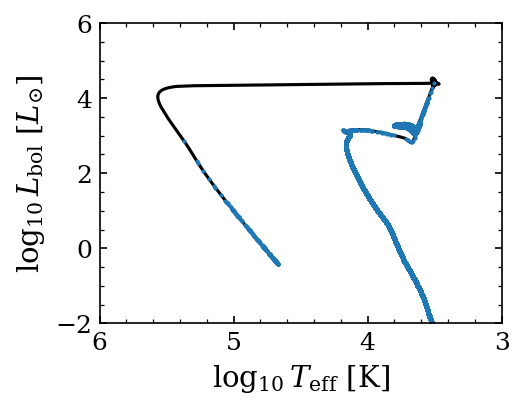

In [5]:
t = np.array([100])*u.Myr
timing = -1*time()
Lbol = sp.lbol_iso(t)
Teff = sp.teff_iso(t)
timing += time()
print(f"Isochrone interpolation time: {timing:.4f} s")

timing = -1*time()
iso = sp.iso.construct_isochrone(t)
timing += time()
print(f"Isochrone construction time: {timing:.4f} s")
plt.plot(iso.qs[iso.lteff_name], iso.qs[iso.llbol_name],'k-')
plt.plot(np.log10(Teff.value), np.log10(Lbol.value), 'o',ms=1)

plt.xlabel(r"$\log_{10} T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L_{\rm bol}$ [$L_{\odot}$]")
plt.xlim(6,3)
plt.ylim(-2,6)

Create a bunch of different stellar population instances with different choices around discrete versus continuous populations and isochrone-based or track-based interpolation. This should take about 8 seconds to initialize.

In [6]:
sp_iso_discrete = ag.StellarPopulation(interp_op="iso")
sp_iso_cont = ag.StellarPopulation(interp_op="iso", discrete=False)
sp_track_discrete = ag.StellarPopulation(interp_op="track")
sp_track_cont = ag.StellarPopulation(interp_op="track", discrete=False)

Test timing for calculating the luminosity of the population at a single time.

In [7]:
t = 1*u.Myr
timing = -1*time()
lbol_discrete = sp_iso_discrete.lbol(t)
timing += time()
print(f"Discrete Calculation with iso interpolation to compute Lbol took: {timing:.2f} s")
timing = -1*time()
lbol_cont = sp_iso_cont.lbol(t)
timing += time()
print(f"Continuous Calculation with iso interpolation to compute Lbol took: {timing:.2f} s")
timing = -1*time()
lbol_discrete_track = sp_track_discrete.lbol(t)
timing += time()
print(f"Discrete Calculation with track interpolation to compute Lbol took: {timing:.2f} s")
timing = -1*time()
lbol_cont_track = sp_track_cont.lbol(t)
timing += time()
print(f"Continuous Calculation with track interpolation to compute Lbol took: {timing:.2f} s")

Discrete Calculation with iso interpolation to compute Lbol took: 0.22 s
Continuous Calculation with iso interpolation to compute Lbol took: 0.06 s
Discrete Calculation with track interpolation to compute Lbol took: 0.57 s
Continuous Calculation with track interpolation to compute Lbol took: 0.45 s


Compute a history of the population's bolometric luminosity for a list of times. This should take about 40 seconds.

In [8]:
tlin = np.logspace(5.1,9,20)*u.yr
lbol_iso_discrete = sp_iso_discrete.lbol(tlin)
lbol_iso_cont = sp_iso_cont.lbol(tlin)
lbol_track_discrete = sp_track_discrete.lbol(tlin)
lbol_track_cont = sp_track_cont.lbol(tlin)

Compare the different results:

Text(0.5, 0, 'Time [yr]')

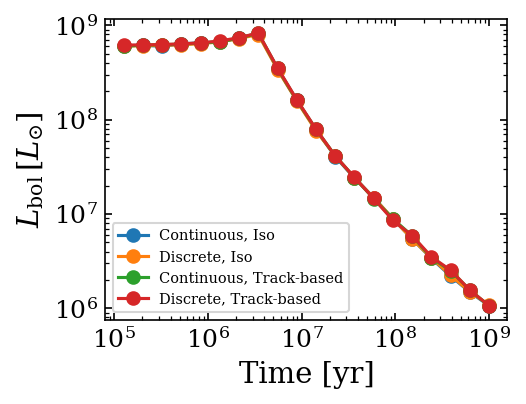

In [9]:
plt.plot(tlin, lbol_iso_cont, 'o-', label="Continuous, Iso")
plt.plot(tlin, lbol_iso_discrete, 'o-', label="Discrete, Iso")
plt.plot(tlin, lbol_track_cont, 'o-', label="Continuous, Track-based")
plt.plot(tlin, lbol_track_discrete, 'o-', label="Discrete, Track-based")
plt.legend(fontsize=7)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$L_{\rm bol} \, [L_{\odot}]$")
plt.xlabel("Time [yr]")

Available parameter space for elemental yields

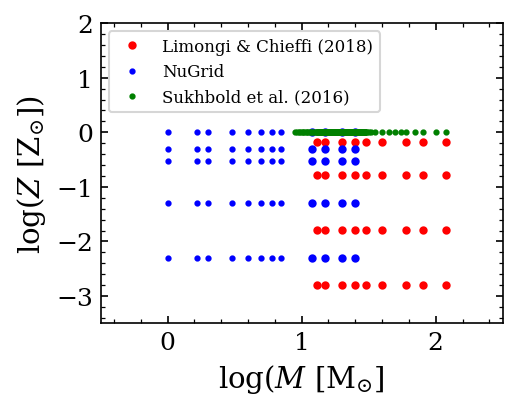

In [10]:
fig = plt.figure()
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}$]")
plt.ylabel(r"$\log(Z\ [{\rm Z}_{\odot}$])")
plt.xlim(-0.5,2.5)
plt.ylim(-3.5, 2)

# Limongi & Chieffi (2018)
lc18 = ag.element_yields.LimongiChieffi2018()
m, Z = np.meshgrid(np.log10(lc18.mass), np.log10(lc18.metal/0.02))
plt.plot(m.flatten(), Z.flatten(), 'o', ms=3, c='r', label=lc18.name)

# NuGrid
ng = ag.element_yields.NuGrid()
m, Z = np.meshgrid(np.log10(ng.lo_mass), np.log10(ng.metal/0.02))
plt.plot(m.flatten(), Z.flatten(), 'o', ms=2, c='b', label=ng.name)
m, Z = np.meshgrid(np.log10(ng.hi_mass), np.log10(ng.metal/0.02))
plt.plot(m.flatten(), Z.flatten(), 'o', ms=3, c='b')

# Sukhbold (2018)
suk18 = ag.element_yields.Sukhbold2016()
m, Z = np.meshgrid(np.log10(suk18.mass), np.log10(0.02/0.02))
plt.plot(m.flatten(), Z.flatten(), 'o', ms=2, c='g', label=suk18.name)

plt.legend(fontsize=8, loc='upper left')
plt.show()

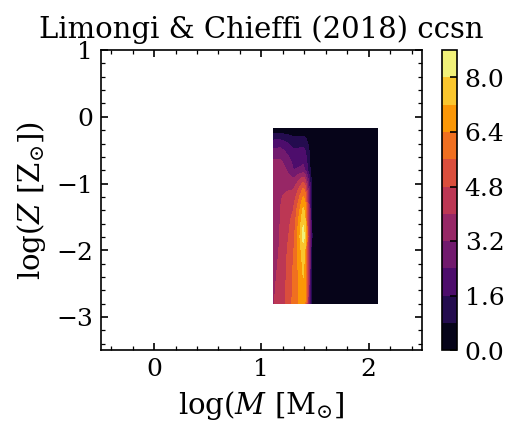

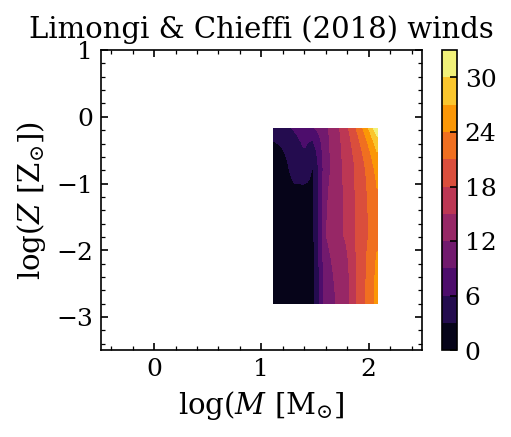

In [11]:
yields = ag.element_yields.LimongiChieffi2018()
mass = np.logspace(np.log10(np.min(yields.mass)), np.log10(np.max(yields.mass)), 64)
met= np.logspace(np.log10(np.min(yields.metal)), np.log10(np.max(yields.metal)), 64)
rot = 0*u.km/u.s

arr_mass, arr_met = np.meshgrid(mass, met)
msp = ag.population.StarPopulation(mass=arr_mass.flatten()*u.M_sun, metals=arr_met.flatten()*u.dimensionless_unscaled, rot=150*u.km/u.s)

fig = plt.figure()
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}$]")
plt.ylabel(r"$\log(Z\ [{\rm Z}_{\odot}$])")
plt.xlim(-0.5,2.5)
plt.ylim(-3.5, 1)

yld = yields.ccsn_yields('H', msp, interpolate='linear')
yld = yld['H'].reshape(arr_mass.shape).value
plt.title(yields.name+" ccsn")
cf = plt.contourf(np.log10(arr_mass), np.log10(arr_met/0.02), yld, levels=10, cmap='inferno')
plt.colorbar(cf)

plt.show()

fig = plt.figure()
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}$]")
plt.ylabel(r"$\log(Z\ [{\rm Z}_{\odot}$])")
plt.xlim(-0.5,2.5)
plt.ylim(-3.5, 1)
yld = yields.wind_yields('H', msp, interpolate='linear')
yld = yld['H'].reshape(arr_mass.shape).value
plt.title(yields.name+" winds")
cf = plt.contourf(np.log10(arr_mass), np.log10(arr_met/0.02), yld, levels=10, cmap='inferno')
plt.colorbar(cf)

plt.show()

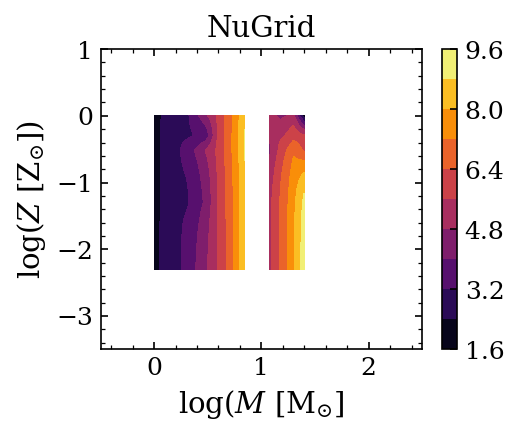

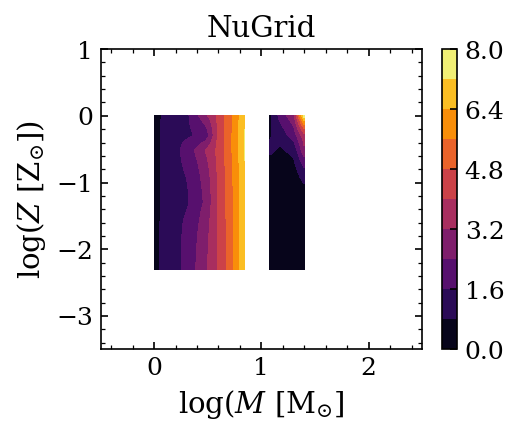

In [12]:
fig = plt.figure()
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}$]")
plt.ylabel(r"$\log(Z\ [{\rm Z}_{\odot}$])")
plt.xlim(-0.5,2.5)
plt.ylim(-3.5, 1)

yields = ag.element_yields.NuGrid()
mass = np.logspace(np.log10(np.min(yields.lo_mass)), np.log10(np.max(yields.lo_mass)), 64)
met= np.logspace(np.log10(np.min(yields.metal)), np.log10(np.max(yields.metal)), 64)
rot = 0*u.km/u.s

arr_mass, arr_met = np.meshgrid(mass, met)
msp = ag.population.StarPopulation(mass=arr_mass.flatten()*u.M_sun, metals=arr_met.flatten()*u.dimensionless_unscaled, rot=150*u.km/u.s)

yld = yields.agb_yields('H', msp, interpolate='linear')
yld = yld['H'].reshape(arr_mass.shape).value
plt.title(yields.name)
cf = plt.contourf(np.log10(arr_mass), np.log10(arr_met/0.02), yld, levels=10, cmap='inferno')

mass = np.logspace(np.log10(np.min(yields.hi_mass)), np.log10(np.max(yields.hi_mass)), 64)
met= np.logspace(np.log10(np.min(yields.metal)), np.log10(np.max(yields.metal)), 64)
rot = 0*u.km/u.s

arr_mass, arr_met = np.meshgrid(mass, met)
msp = ag.population.StarPopulation(mass=arr_mass.flatten()*u.M_sun, metals=arr_met.flatten()*u.dimensionless_unscaled, rot=150*u.km/u.s)

yld = yields.ccsn_yields('H', msp, interpolate='linear')
yld = yld['H'].reshape(arr_mass.shape).value
cf = plt.contourf(np.log10(arr_mass), np.log10(arr_met/0.02), yld, levels=10, cmap='inferno')
plt.colorbar(cf)

plt.show()

fig = plt.figure()
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}$]")
plt.ylabel(r"$\log(Z\ [{\rm Z}_{\odot}$])")
plt.xlim(-0.5,2.5)
plt.ylim(-3.5, 1)

yields = ag.element_yields.NuGrid()
mass = np.logspace(np.log10(np.min(yields.lo_mass)), np.log10(np.max(yields.lo_mass)), 64)
met= np.logspace(np.log10(np.min(yields.metal)), np.log10(np.max(yields.metal)), 64)
rot = 0*u.km/u.s

arr_mass, arr_met = np.meshgrid(mass, met)
msp = ag.population.StarPopulation(mass=arr_mass.flatten()*u.M_sun, metals=arr_met.flatten()*u.dimensionless_unscaled, rot=150*u.km/u.s)

yld = yields.agb_yields('H', msp, interpolate='linear')
yld = yld['H'].reshape(arr_mass.shape).value
plt.title(yields.name)
cf = plt.contourf(np.log10(arr_mass), np.log10(arr_met/0.02), yld, levels=10, cmap='inferno')

mass = np.logspace(np.log10(np.min(yields.hi_mass)), np.log10(np.max(yields.hi_mass)), 64)
met= np.logspace(np.log10(np.min(yields.metal)), np.log10(np.max(yields.metal)), 64)
rot = 0*u.km/u.s

arr_mass, arr_met = np.meshgrid(mass, met)
msp = ag.population.StarPopulation(mass=arr_mass.flatten()*u.M_sun, metals=arr_met.flatten()*u.dimensionless_unscaled, rot=150*u.km/u.s)

yld = yields.wind_yields('H', msp, interpolate='linear')
yld = yld['H'].reshape(arr_mass.shape).value
cf = plt.contourf(np.log10(arr_mass), np.log10(arr_met/0.02), yld, levels=10, cmap='inferno')
plt.colorbar(cf)

plt.show()

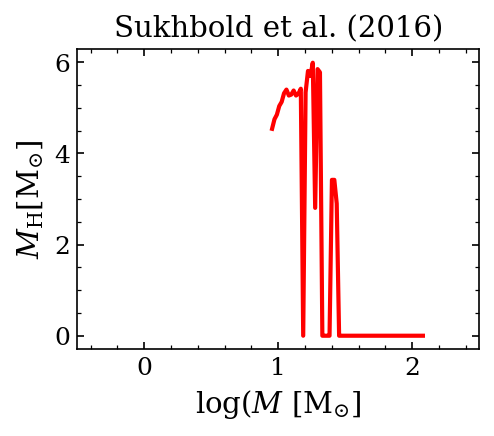

In [13]:
fig = plt.figure()
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}]$")
plt.ylabel(r"$M_{\rm H} [{\rm M}_{\odot}]$")
plt.xlim(-0.5,2.5)

yields = ag.element_yields.Sukhbold2016()
mass = np.logspace(np.log10(np.min(yields.mass)), np.log10(np.max(yields.mass)), 64)
met = 0.02*u.dimensionless_unscaled
rot = 0*u.km/u.s

msp = ag.population.StarPopulation(mass=mass*u.M_sun, metals=met, rot=rot)

yld = yields.ccsn_yields('H', msp, interpolate='nearest')
yld = yld['H'].value

plt.title(yields.name)
plt.plot(np.log10(mass), yld, '-r', lw=2)

plt.show()

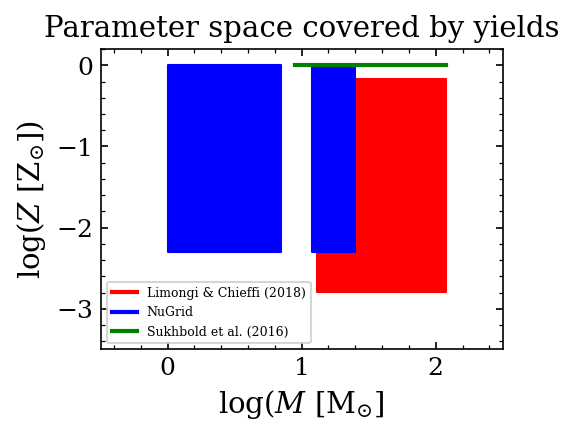

In [14]:
fig = plt.figure()
plt.title("Parameter space covered by yields")
plt.xlabel(r"$\log(M\ [{\rm M}_{\odot}$]")
plt.ylabel(r"$\log(Z\ [{\rm Z}_{\odot}$])")
plt.xlim(-0.5,2.5)
plt.ylim(-3.5, 0.2)
Zsol = 0.02
# Limongi & Chieffi (2018)
lc18 = ag.element_yields.LimongiChieffi2018()
plt.fill_between(np.log10(lc18.mass), y1=np.min(np.log10(lc18.metal/Zsol)), y2=np.max(np.log10(lc18.metal/Zsol)), color='r')
plt.plot([],[], '-r', label=lc18.name, lw=2)

# NuGrid
ng = ag.element_yields.NuGrid()
plt.fill_between(np.log10(ng.lo_mass), y1=np.min(np.log10(ng.metal/Zsol)), y2=np.max(np.log10(ng.metal/Zsol)), color='b')
plt.fill_between(np.log10(ng.hi_mass), y1=np.min(np.log10(ng.metal/Zsol)), y2=np.max(np.log10(ng.metal/Zsol)), color='b')
plt.plot([],[], '-b', label=ng.name, lw=2)

# Sukhbold (2018)
suk18 = ag.element_yields.Sukhbold2016()
plt.plot(np.log10(suk18.mass), np.ones_like(suk18.mass)*np.log10(suk18.metal/0.02), '-', lw=2, c='g', label=suk18.name)

plt.legend(fontsize=6, loc='lower left')
plt.show()